In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [13]:
def autocorr(x,k):
  x = x.reshape(-1,1)
  return sm.tsa.acf(x)[1]

def thomasfiering(x,T,N):
  # set random seed
  np.random.seed(5)

  # Log Transform of Data
  x = np.log(x)

  # Mean, Variance, Autocorrelation
  mu = x.mean()
  sigma = x.std()
  rho = autocorr(x,1)

  # Initializing NxT matrix where N is the number of simulations T is lnegth of time series
  Q = np.zeros([N,T])
  Q[:,0] = np.random.normal(mu, sigma, 1)

  # Simulate AR(1) for each year
  for i in range(1,T):
    Z = np.random.standard_normal(N)
    Q[:,i] = mu + rho*(Q[:,i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)

  return np.exp(Q)

In [14]:
data = pd.read_csv('nashville_daily_1992_2022.txt', sep='\t')
data = data.drop(['129904_00060_00003_cd', 'agency_cd', 'site_no'], axis=1)
data = data.drop(0, axis=0)
data = data.rename(columns={'datetime':'Date', '129904_00060_00003':'Flow'})
data['Date'] = pd.to_datetime(data["Date"], format='%Y/%m/%d')
data['Year'] = data['Date'].dt.year

# Fill NaN values
data['Flow'] = data["Flow"].fillna(method='ffill')
data['Flow'] = data['Flow'].astype(float)
dailyQ = data
years = np.unique(dailyQ['Year'])

# Delete Leap Days
dailyQ = dailyQ[~((dailyQ.Date.dt.month==2)&(dailyQ.Date.dt.day==29))]

# Delete first and last year
dailyQ = dailyQ[~(dailyQ['Year']==2022)]
dailyQ = dailyQ[~(dailyQ['Year']==1992)]

In [15]:
# Annual Mean Flow 
annQ = np.array(dailyQ.groupby(data["Year"]).mean()['Flow'])
annQ = annQ

In [16]:
# Use thomas Fiering Model to simulate annual flow time series
annQsyn = thomasfiering(annQ, T=100, N=1)
annQsyn = annQsyn[0]

Text(0.5, 1.0, 'Historical Mean Annual Flows')

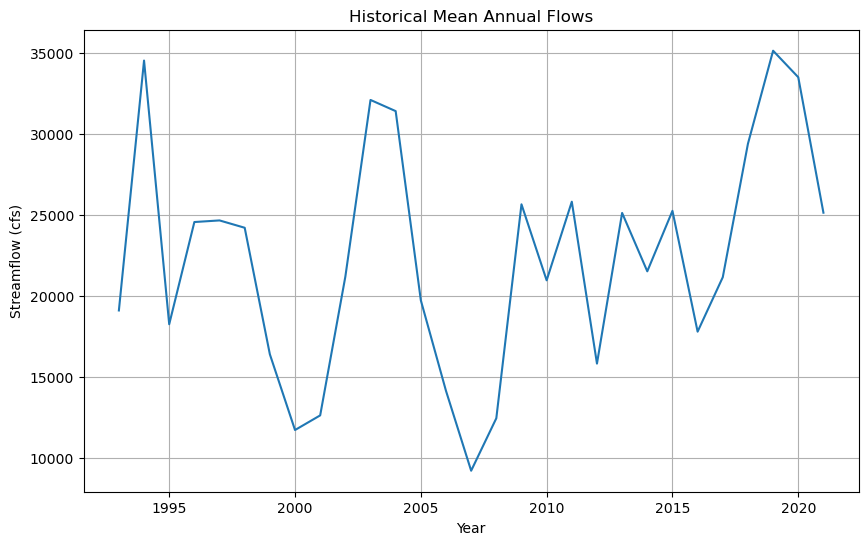

In [17]:
plt.figure(figsize = (10,6))
plt.plot(np.arange(1993,2022),annQ)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Streamflow (cfs)')
plt.title('Historical Mean Annual Flows')

NameError: name 'T' is not defined

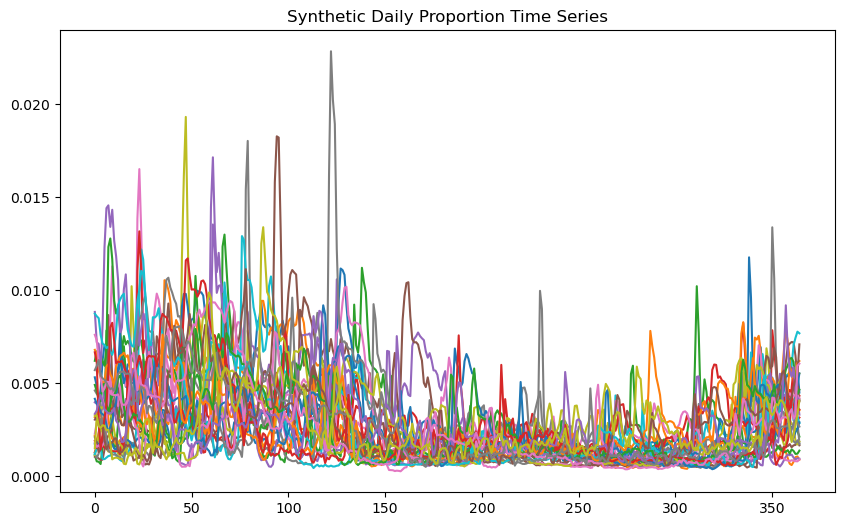

In [18]:
# K-nn disaggregation

# Daily Proportion matrix form historical data

# Reshape daily data into matrix
dailyQmatrix = np.array(dailyQ['Flow']).reshape(-1,365)

# annual sum of each row
annSum = np.sum(dailyQmatrix,1)

# Normalized daily values
P = dailyQmatrix / annSum[:,None]

# Check that daily sum values sum to one
assert np.sum(np.abs(np.sum(P,1)-1) > 0.0001) == 0, 'rows should sum to 1'

plt.figure(figsize = (10,6))
plt.plot(P.T)
plt.title('Synthetic Daily Proportion Time Series')

plt.savefig('synthetic.png', transparent = T)


In [19]:
# Resample using k-nn

N = len(annQ)
k =np.int(np.sqrt(N))

# INitialize resampled matrix
dailyQresampled = np.zeros([N,365])

# Find indices of the k nearest neighbors 
for i in range(N):
  kNN_ind = np.argsort(np.abs(annQsyn[i] - annQ))[0:k]

  #Calculate weights and check they sum to 1
  W = [(1/i) / np.sum(1/np.arange(1,k+1)) for i in np.arange(1,k+1)]
  assert (np.sum(W)-1) < 0.001, 'weights should sum to 1'

  # Sample a year from the hsitorical record with weights W
  cumW = np.cumsum(W)
  rnd = np.random.rand()
  samp_ind = kNN_ind[np.where(rnd < cumW)[0][0]]

  # GEt daily proportion series fro sampled year and use to disaggregate 
  # annual synthetic flow to daily flow
  dailyQresampled[i,:] = annQsyn[i] * P[samp_ind, :] * 365


/var/folders/9v/gbghw4697p5219tnn983g81w0000gn/T/ipykernel_9786/1104097631.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k =np.int(np.sqrt(N))


In [20]:
cumW

array([0.4379562 , 0.65693431, 0.80291971, 0.91240876, 1.        ])

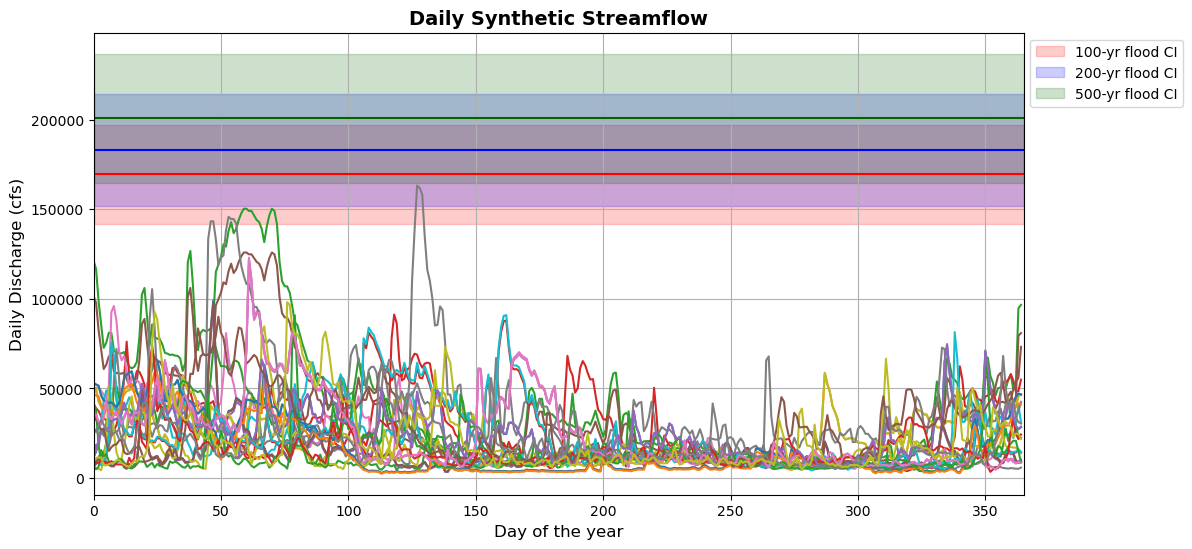

In [29]:
# Plot synthetic daily flows
meanDailyQ = np.mean(np.array(dailyQ['Flow']).reshape(365,-1))
plt.figure(figsize=(12,6))
plt.plot(dailyQresampled.T)
plt.grid()
plt.xlim([0,365])

%store -r hun_yr_flood
%store -r five_hun_yr_flood
%store -r ci100
%store -r ci500
%store -r two_hun_yr_flood
%store -r ci200

plt.hlines( [hun_yr_flood, two_hun_yr_flood, five_hun_yr_flood], 0, 365, color=['red', 'blue', 'darkgreen'])
plt.fill_between([0,365], (ci100[0]), (ci100[1]), color='r', alpha=.2, label='100-yr flood CI')
plt.fill_between([0,365], (ci200[0]), (ci200[1]), color='b', alpha=.2, label='200-yr flood CI')
plt.fill_between([0,365], (ci500[0]), (ci500[1]), color='darkgreen', alpha=.2, label='500-yr flood CI')
plt.xlabel('Day of the year', fontsize=12)
plt.ylabel('Daily Discharge (cfs)', fontsize=12)
plt.title('Daily Synthetic Streamflow', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1)

plt.savefig('synthetic.png', transparent = True)

In [26]:
sim100yr = pd.read_excel('100-yr-30daySim.xlsx', header=None).rename(columns={0:'Flow'})
sim200yr = pd.read_excel('200-yr-30daySim.xlsx', header=None).rename(columns={0:'Flow'})

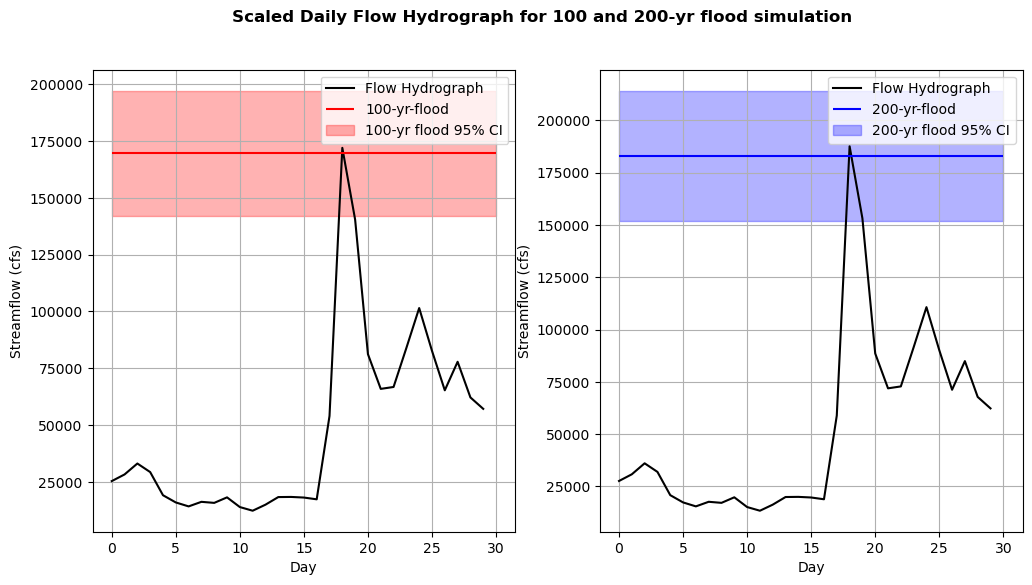

In [28]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.grid()
plt.plot(sim100yr, 'k', label='Flow Hydrograph')
plt.hlines(hun_yr_flood, 0, 30, color = 'red', label='100-yr-flood')
plt.fill_between([0,30], ci100[0], ci100[1], color='red', alpha=.3, label = '100-yr flood 95% CI')
plt.xlabel('Day')
plt.ylabel('Streamflow (cfs)')
plt.legend()

plt.subplot(1,2,2)
plt.grid()
plt.plot(sim200yr, 'k', label='Flow Hydrograph')
plt.hlines(two_hun_yr_flood, 0, 30, color = 'blue', label='200-yr-flood')
plt.fill_between([0,30], ci200[0], ci200[1], color='blue', alpha=.3, label = '200-yr flood 95% CI')
plt.xlabel('Day')
plt.ylabel('Streamflow (cfs)')
plt.legend(loc='best')

plt.suptitle('Scaled Daily Flow Hydrograph for 100 and 200-yr flood simulation', weight='bold')
plt.savefig('hydro.png', transparent = True)

In [25]:
colors = plt.cm.plasma(np.arange(0,200))